In [ ]:
import numpy as np
import random
from numpy.random import choice as np_choice
import matplotlib.pyplot as plt

In [ ]:
class AntColony:
    def __init__(self, distances, pheromones, q, n_ants, n_best, n_interations, decay, alpha=1, beta=1):
        self.distances = distances                 # Vetor com as cidades
        self.pheromones = pheromones               # Vetor com os feromonios
        self.rand_dist = range(len(distances))     # Cidades a serem escolhidas
        self.n_ants = n_ants                       # Numero total de formigas
        self.n_best = n_best                       # Numero total de melhores casos
        self.n_interations = n_interations         # Numero maximo de gerações
        self.decay = decay                         # Evaporação do feromonio
        self.alpha = alpha                         # Controle Alpha
        self.beta = beta                           # Controle Beta
        self.all_best = []                         # Vetor com os melhores casos
        self.first_i = []                          # Vetor guarda as rota da primeira iteração
        self.q = q                                 # Quantidade de feromonio a ser
                                                   #   depositado
        self.all_time_shortest_path = ([], np.inf) # Melhor rota
        self.cities_n = [i for i in range(len(self.distances[0]))]

    def run(self):
        shortest_path = None

        for x in range(self.n_interations):
            # Gera as rotas das formigas
            all_paths = self.gen_n_tour()

            # Espalha os feromonios
            self.spread_pheromone(all_paths)

            # Guarda a melhor rota da geração
            shortest_path = min(all_paths, key=lambda x: x[1])

            # Verifica se a rota mais rapida da geração é a mais rapida já
            # feita
            if shortest_path[1] < self.all_time_shortest_path[1]:
                self.all_best.append(shortest_path[1])
                self.all_time_shortest_path = shortest_path
            else:
                self.all_best.append(self.all_time_shortest_path[1])

            # Aplica a evaporação dos feromonios ao fim de uma geração
            self.pheromones = np.multiply(self.pheromones, self.decay)

            # Guarda o resultado da primeira iteração
            if x == 0:
                self.first_i = all_paths
        return self.all_time_shortest_path

    def verify_path(self, path):
        hits = []
        for city in path:
            for c in self.all_time_shortest_path[0]:
                if set(city + c) == 2:
                    hits.append(city)

        return hits
    
    def spread_pheromone(self, all_paths):
        """Espalha o feromonio pela rota
        | @param: all_paths = Lista de todas as rotas
        """

        # Espalha os feromonios
        for path, _ in all_paths:
            hits = self.verify_path(path)

            for hit in hits:
                self.pheromones[hit] += self.q / self.calc_tour_distance(path)

    def calc_tour_distance(self, path):
        """Calcula a distancia de todas as cidades percorridas em um tour
        """
        total_dist = 0
        for i in path:
            total_dist += self.distances[i]
        return total_dist

    def gen_n_tour(self):
        global VERBOSE
        all_paths = []

        # Embaralha as cidades
        np.random.shuffle(self.cities_n)

        # Gera todos as viagens das formigas
        for i in range(self.n_ants):
            path = self.gen_tour(self.cities_n[i])
            if VERBOSE:
                print(f"ANT-{i} --PATH--> {path}")
            all_paths.append((path, self.calc_tour_distance(path)))
        return all_paths

    def gen_tour(self, start):
        path = []

        # Guarda as cidades visitadas
        visited = set()
        visited.add(start)
        prev = start

        # Gera um tour de uma formiga
        for _ in range(len(self.distances) - 1):
            move = self.prob_move(self.pheromones[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))
        return path
    
    def prob_move(self, pheromone, dist, visited):
        """Calcula a probabilidade da formiga escolher uma direção
        | @param: pheromone = Lista de feromonios
        | @param: dist      = Lista das cidades
        | @param: visited   = Lista das cidades visitadas pela formiga
        """
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        # Nota das cidades
        den = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)

        prob_tr = den / den.sum() # Calculo da probabilidade de transição

        # Escolhe o proximo movimento com base na probabilidade de transição
        # A formiga tem uma chance minima de não seguir a rota com maior feromonio
        move = np_choice(self.rand_dist, 1, p=prob_tr)[0]
        return move

In [ ]:
DISTANCES = np.array([
        [np.inf, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, np.inf, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, np.inf, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, np.inf, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, np.inf, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, np.inf, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, np.inf, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, np.inf, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, np.inf, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, np.inf, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, np.inf, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, np.inf, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, np.inf],
])

PHEROMONES = np.array([
    [np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, np.inf],
])

P_I             = 0.1 # Minimo de feromonio para iniciar a tabela
P_M             = 0.4 # Maximo de feromonio para iniciar a tabela

PHEROMONES = np.array([[random.uniform(P_I, P_M) if x != np.inf else np.inf for x in y] for y in PHEROMONES])

arr_size = len(PHEROMONES[0])
print(f"N_ANTS -> {arr_size}")

VERBOSE         = False
MAX_INTERATIONS = 2000
EL              = 0.90
ALPHA           = 1
BETA            = 4
Q               = 0.3
N_ANTS          = arr_size

N_ANTS -> 13


# Roda a aplicação

In [ ]:
ant_colony = AntColony(DISTANCES, PHEROMONES, Q, N_ANTS, 1, MAX_INTERATIONS, EL, alpha=ALPHA, beta=BETA)
shortest_path = ant_colony.run()
first_i = ant_colony.first_i

Distância esperada : **7293**

Rota esperada:
**0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0**

fonte: https://developers.google.com/optimization/routing/tsp

In [ ]:
print(f"SHORTEST PATH: {shortest_path}")

SHORTEST PATH: ([(0, 7), (7, 2), (2, 3), (3, 4), (4, 12), (12, 6), (6, 8), (8, 1), (1, 11), (11, 10), (10, 5), (5, 9), (9, 0)], 7293.0)


In [ ]:
# [x, y]
cities = np.copy(DISTANCES[0]).tolist()
cities_pos = [
              [1, 16], 
              [28, 7], 
              [3, 3],  
              [7, 2],  
              [7, 10], 
              [40, 14],
              [23, 1], 
              [1, 5],  
              [25, 0], 
              [26, 15],
              [38, 13],
              [30, 11],
              [13, 8] 
]

# Primeira iteração

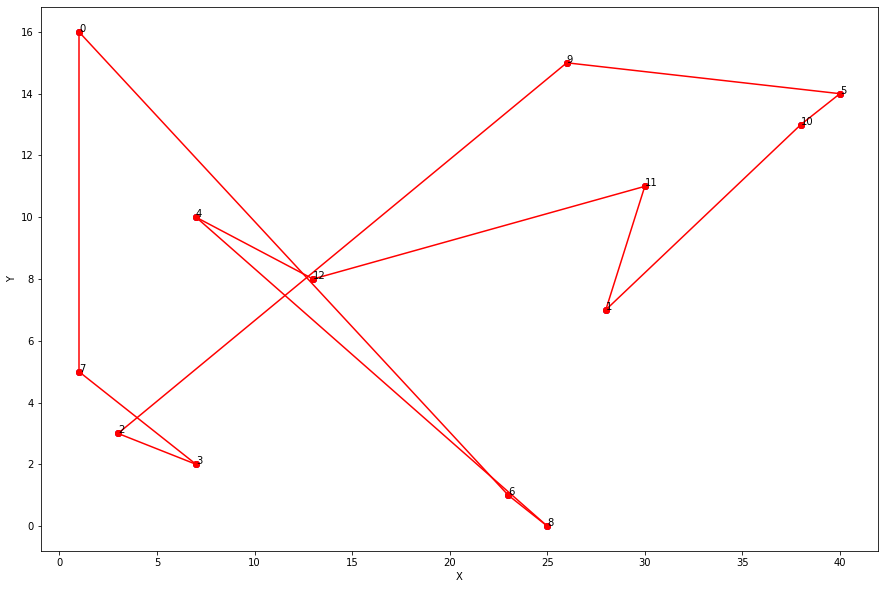

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

for i, city in enumerate(cities):
    plt.plot(cities_pos[i][0], cities_pos[i][1], marker="o", color="b")
    plt.annotate(i, (cities_pos[i][0], cities_pos[i][1]))

for i, trip in enumerate(first_i[0][0]):
    p1 = trip[0]
    p2 = trip[1]
    p1x, p1y = cities_pos[p1][0], cities_pos[p1][1]
    p2x, p2y = cities_pos[p2][0], cities_pos[p2][1]
    plt.plot([p2x, p1x], [p2y, p1y], 'ro-')

plt.ylabel("Y")
plt.xlabel("X")
plt.show()

# Melhor rota

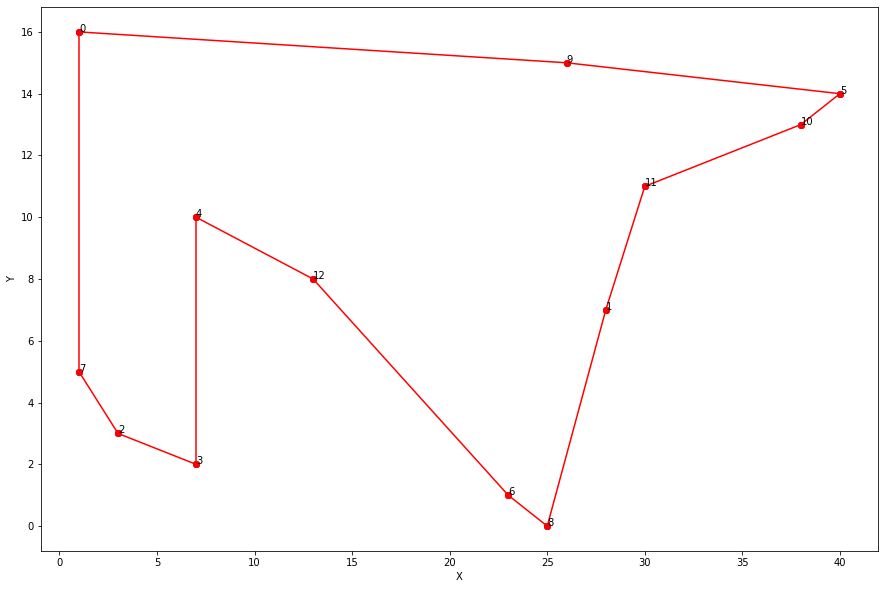

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

for i, city in enumerate(cities):
    plt.plot(cities_pos[i][0], cities_pos[i][1], marker="o", color="b")
    plt.annotate(i, (cities_pos[i][0], cities_pos[i][1]))

for i, trip in enumerate(shortest_path[0]):
    p1 = trip[0]
    p2 = trip[1]
    p1x, p1y = cities_pos[p1][0], cities_pos[p1][1]
    p2x, p2y = cities_pos[p2][0], cities_pos[p2][1]
    plt.plot([p2x, p1x], [p2y, p1y], 'ro-')

plt.ylabel("Y")
plt.xlabel("X")
plt.show()